In [1]:
# Import the necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import the data
df = pd.read_csv("listings-03-29-21-09.csv")


### Let's Take a peak at the data

In [3]:
df.head()

,Category,Yard,Parking Type,heating,State,City,Zip,Seller Type,School District,Seller Accepts Texts,...,Exterior Material,cooling,Bathrooms,Bedrooms,Ad Status,Special Features,Floor Covering,Basement Type,Included Appliances,mls number
0,townhouse/condo,fenced full,attached garage|combined garage|2 cars,forced air,ut,herriman,84096,by agent,jordan,True,...,clapboardmasonite|stucco,central air,3.75,4,active,fireplace gas|patio uncovered|pool|security sy...,carpet|hardwood|linoleum,full finished,microwave|range|refrigerator,1587020
1,single family home,landscape full,attached garage|combined garage|3 cars,forced air,ut,farmington,84025,by agent,not specified,True,...,other|stucco,central air,2.50,4,active,not specified,carpet|hardwood|other|tile,not specified,microwave|refrigerator,3051017
2,single family home,fenced full|landscape full,attached garage|combined garage|2 cars,forced air,ut,lehi,84043,by agent,alpine,True,...,stucco,central air,3.00,5,active,fireplace gas|sprinklers automatic|walkin closet,carpet|tile,full unfinished,microwave|range,1589044
3,single family home,fenced partial|landscape full,attached garage|combined garage|2 cars,forced air,ut,delta,84624,by agent,millard,True,...,stucco,central air,3.00,6,active,fireplace woodburning|patio covered|sprinklers...,carpet|tile,full finished,not specified,1570632
4,single family home,fenced partial,attached garage|combined garage|2 cars,forced air,ut,bountiful,84010,by owner,davis,True,...,brick|cedarredwood,central air,3.00,4,active,deck|fireplace gas|fireplace woodburning|patio...,carpet|hardwood|tile,full finished,dryer|microwave|range|refrigerator|washer,not specified


There are a lot of features that probably won't do us much good. (e.g. MLS # or State as we're only handling Utah houses) Also notice how many of the interesting features like Parking Type and Exterior Material are strings of smaller features, let's try and pull those out.

In [4]:
# Adjust formats as needed

# Adjust appropriate strings to numerics
df['Acres'] = pd.to_numeric(df['Acres'], errors='coerce')
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
df['Year Built'] = pd.to_numeric(df['Year Built'], errors='coerce', downcast='integer')
df['Square Feet'] = pd.to_numeric(df['Square Feet'], errors='coerce', downcast='integer')

# # Adjust some features to categories
# df['Seller Type'] = df['Seller Type'].astype('category')
# df['cooling'] = df['cooling'].astype('category')
# df['heating'] = df['heating'].astype('category')
# df['Basement Type'] = df['Basement Type'].astype('category')
# df['Category'] = df['Category'].astype('category')


In [5]:
# Break some categories into more nuanced ones
df['Carpet'] = pd.np.where(df['Floor Covering'].str.contains("carpet"), True, False)
df['Hard Wood'] = pd.np.where(df['Floor Covering'].str.contains("hardwood"), True, False)
df['Tile'] = pd.np.where(df['Floor Covering'].str.contains("tile"), True, False)
df['Laminate'] = pd.np.where(df['Floor Covering'].str.contains("laminate"), True, False)

df['Finished Basement'] = pd.np.where(df['Basement Type'].str.contains("full finished|full partially finished"), True, False)

df['Garage'] = pd.np.where(df['Parking Type'].str.contains("garage"), True, False)

df['Fireplace'] = pd.np.where(df['Special Features'].str.contains("fireplace"), True, False)
df['Deck'] = pd.np.where(df['Special Features'].str.contains("deck"), True, False)
df['Sprinklers'] = pd.np.where(df['Special Features'].str.contains("sprinklers"), True, False)
df['Pool'] = pd.np.where(df['Special Features'].str.contains("pool"), True, False)

df['By Owner'] = pd.np.where(df['Seller Type'].str.contains("by owner"), True, False)

df['Washer'] = pd.np.where(df['Included Appliances'].str.contains("washer"), True, False)
df['Dryer'] = pd.np.where(df['Included Appliances'].str.contains("dryer"), True, False)

df['Fenced'] = pd.np.where(df['Yard'].str.contains("fenced full|fenced partial"), True, False)
df['Landscape'] = pd.np.where(df['Yard'].str.contains("landscape full|landscape partial|landscape front|landscape back"), True, False)

df['Central Air'] = pd.np.where(df['cooling'].str.contains("central air"), True, False)

df['Brick'] = pd.np.where(df['Exterior Material'].str.contains("brick"), True, False)
df['Stucco'] = pd.np.where(df['Exterior Material'].str.contains("stucco"), True, False)

#### Now that we've created some new columns from the old ones of features let's drop those old columns and remove some outliers that will throw off our models. 

In [6]:
# Drop Non-Utah Listings
df = df[df['State'] == "ut"]

# Drop useless features
uselessFeatures = ['Ad Status', 'Package Type', 'mls number', 'AD ID', 'Title']
df = df.drop(uselessFeatures, axis=1)

# Obsolete because we formed simple boolean columns from them
obsoleteFeatures = ['State', 'Exterior Material', 'Parking Type', 'cooling', 'heating', 'Basement Type', 'Seller Type', 'Included Appliances']
df = df.drop(obsoleteFeatures, axis=1)


# Drop Extreme price outliers (between 50k and 5m)
df = df[df['Asking Price'] < 5000000] 
df = df[df['Asking Price'] > 50000]

# Drop improper years
df = df[df['Year Built'] > 1850]

# Drop extremely high/low Sqaure Feet listings (11000sqft = .25 acre (roughly))
df = df[df['Square Feet'] < 11000]
df = df[df['Square Feet'] > 500]



In [7]:
df.dtypes


Category                 object
Yard                     object
City                     object
Zip                      object
School District          object
Seller Accepts Texts       bool
Photo Count               int64
Year Built              float64
Acres                   float64
Square Feet             float64
Newly Built                bool
Seller ID                 int64
Time Posted              object
Asking Price              int64
Bathrooms               float64
Bedrooms                float64
Special Features         object
Floor Covering           object
Carpet                     bool
Hard Wood                  bool
Tile                       bool
Laminate                   bool
Finished Basement          bool
Garage                     bool
Fireplace                  bool
Deck                       bool
Sprinklers                 bool
Pool                       bool
By Owner                   bool
Washer                     bool
Dryer                      bool
Fenced  

### Let's look at how correlated these all are with a correlation heatmap

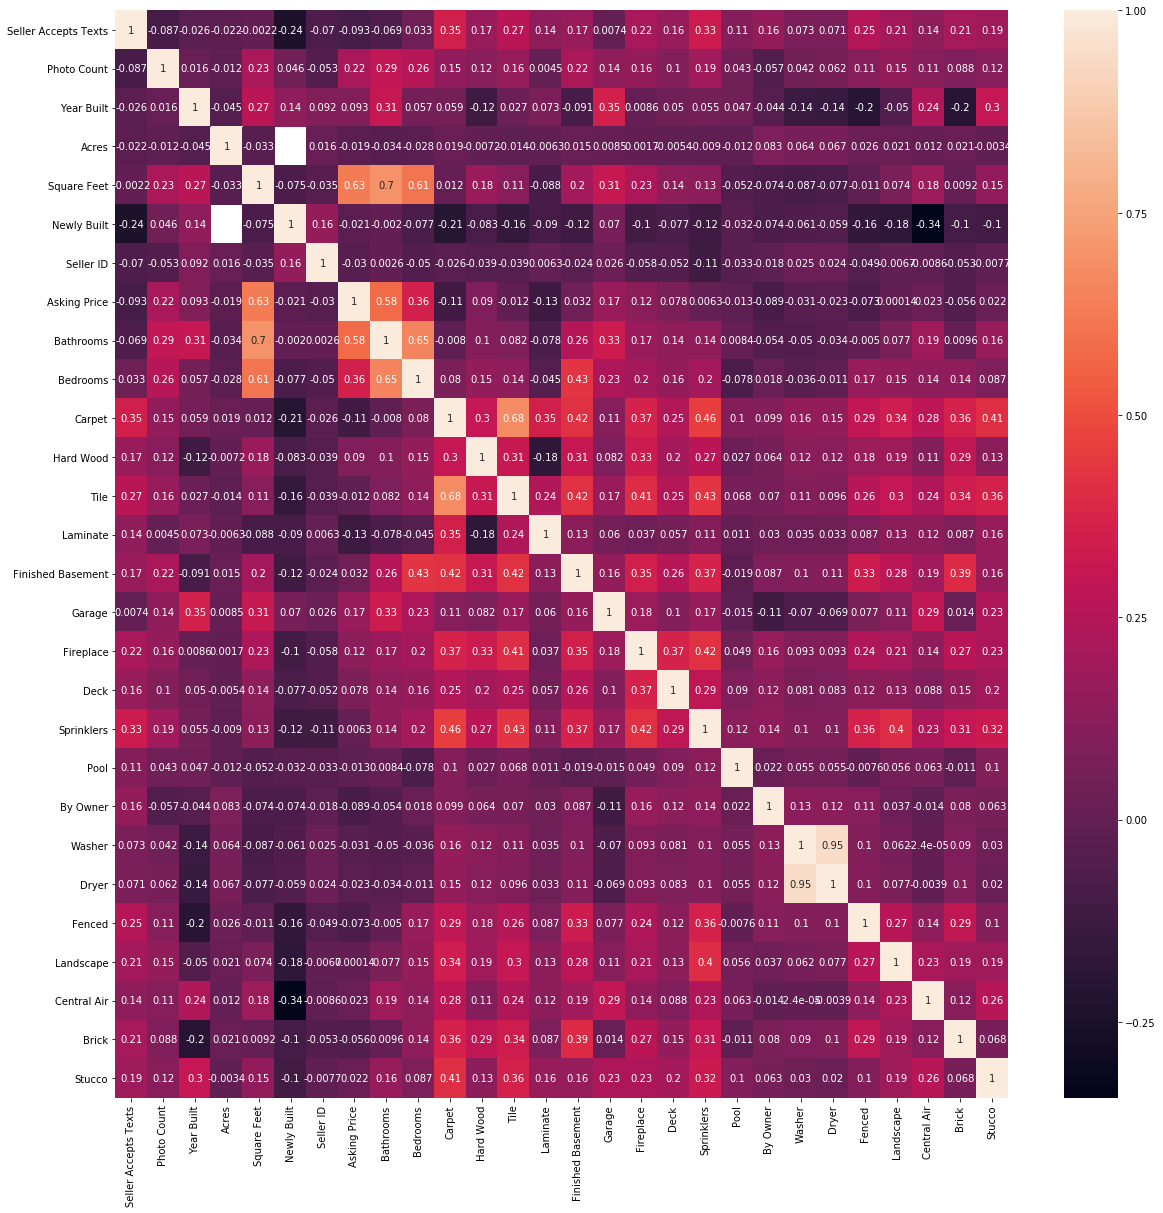

In [8]:
# calculate the correlation matrix
corr = df.corr()

# plot the correlation heatmap
plt.figure(figsize=(20, 20))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

#### Hmm, not that great. Let's simply out analysis to just the clearly significant features for now.

In [9]:
# Save the newly formatted DataFrame to a csv again
# df.to_csv (r'export_dataframe.csv', index = None, header=True) 

quant_feats = ['Asking Price', 'Bedrooms', 'Bathrooms', 'Year Built', 'Square Feet']
df2 = df[quant_feats].copy()

# reg_df = df[['Asking Price', 'Bedrooms', 'Bathrooms','Category',
#              'Seller Accepts Texts', 'Photo Count', 'Year Built',
#              'Acres', 'Square Feet', 'Newly Built', 'Carpet', 'Hard Wood',
#              'Tile', 'Laminate', 'Finished Basement', 'Garage', 'Fireplace',
#              'Deck', 'Sprinklers', 'Pool', 'By Owner', 'Washer', 'Dryer',
#              'Fenced', 'Landscape', 'Central Air', 'Brick', 'Stucco']]

# Let's drop the NaN values while we're at it
df2 = df2.dropna()


In [10]:
df2.head()

,Asking Price,Bedrooms,Bathrooms,Year Built,Square Feet
0,289900,4.0,3.75,2011.0,2218.0
1,450000,4.0,2.50,2006.0,2400.0
2,414900,5.0,3.00,2006.0,3617.0
3,235000,6.0,3.00,1986.0,2576.0
4,365000,4.0,3.00,1975.0,2900.0


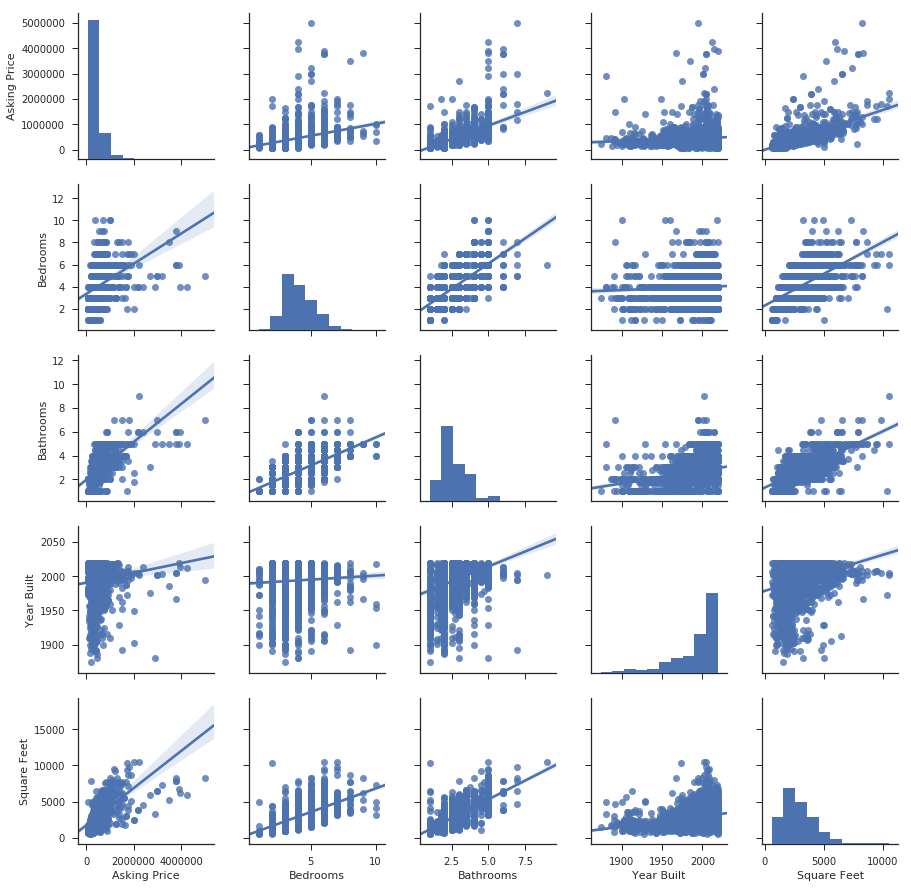

In [11]:
# Initial EDA Charts
sns.set(style='ticks')
sns.pairplot(df2, kind='reg')

Function to create splits for training validating and testing

In [12]:
def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

### Split data into Train Test and Validation sets

In [13]:
train_size, valid_size, test_size = (65, 30, 5)
df_train, df_valid, df_test = train_validate_test_split(df2, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=2019)

In [14]:
df_y_train = df2.loc[df_train, ['Asking Price']]
df_x_train = df2.loc[df_train, :].drop("Asking Price", axis=1)
df_y_valid = df2.loc[df_valid, ['Asking Price']]
df_x_valid = df2.loc[df_valid, :].drop("Asking Price", axis=1)
df_x_test = df2.loc[df_test, :].drop("Asking Price", axis=1)
df_y_test = df2.loc[df_test, ['Asking Price']]

print('Size of training set: ', len(df_x_train))
print('Size of validation set: ', len(df_x_valid))
print('Size of test set: ', len(df_test))

Size of training set:  1467
Size of validation set:  677
Size of test set:  113


Function to get statistics about a data frame.

In [15]:

def norm_stats(df1, df2, df3):
    dfs = df1.append(df2)
    dfs = df1.append(df3)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

Function to Z-normalise the entire data frame - note stats for Z transform passed in.

In [16]:
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

Normalise training and validation predictors using the stats from training data only (to ensure the same transformation applies to both training and validation data), and then convert them into numpy arrays to be used by Keras.

In [17]:
stats = norm_stats(df_x_train, df_x_valid, df_x_test)
arr_x_train = np.array(z_score(df_x_train, stats))
arr_y_train = np.array(df_y_train)
arr_x_valid = np.array(z_score(df_x_valid, stats))
arr_y_valid = np.array(df_y_valid)
arr_x_test = np.array(z_score(df_x_test, stats))
arr_y_test = np.array(df_y_test)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])
print('Test samples: ', arr_x_test.shape[0])

Training shape: (1467, 4)
Training samples:  1467
Validation samples:  677
Test samples:  113


### Three functions to define alternative Keras models

In [18]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


The first is very simple, consisting of three layers and Adam optimizer.

In [19]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

The second with Adam optimizer consists of 4 layers and the first uses 10% dropouts.

In [20]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

The third is the most complex, it extends the previous model with Nadam optimizer, dropouts and L1/L2 regularisers.

In [21]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

Now we create the model - use one of the above functions

In [22]:
model = basic_model_2(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               500       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 6,591
Trainable params: 6,591
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
den

### Fit/Train Keras model

Define how many epochs of training should be done and what is the batch size.

In [23]:
epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  500
Batch size:  128


Specify Keras callbacks which allow additional functionality while the model is being fitted.

-  ModelCheckpoint allows to save the models as they are being built or improved.
-  TensorBoard interacts with TensorFlow interactive reporting system.
-  EarlyStopping watches one of the model measurements and stops fitting when no improvement

In [24]:
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

Fit the model and record the history of training and validation.<br>
As we specified EarlyStopping with patience=20, with luck the training will stop in less than 200 epochs.<br>
__Be patient, the fitting process takes time, use verbose=2 for visual feedback.__

In [25]:
history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

### Evaluate and report performance of the trained model

In [26]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  114004.7225 , Train Loss:  65820084661.6605
Val MAE:  114903.7662 , Val Loss:  54187030597.5775


This function allows plotting of the training history

In [27]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

Now plot the training history, i.e. the Mean Absolute Error and Loss (Mean Squared Error), which were both defined at the time of model compilation. Note that the plot shows validation error as less than training error, which is quite deceptive. The reason for this is that training error is calculated for the entire epoch (and at its begining it was much worse than at the end), whereas the validation error is taken from the last batch (after the model improved). See the above evaluation statistics to confirm that the evaluation puts these errors in the correct order at the very end.

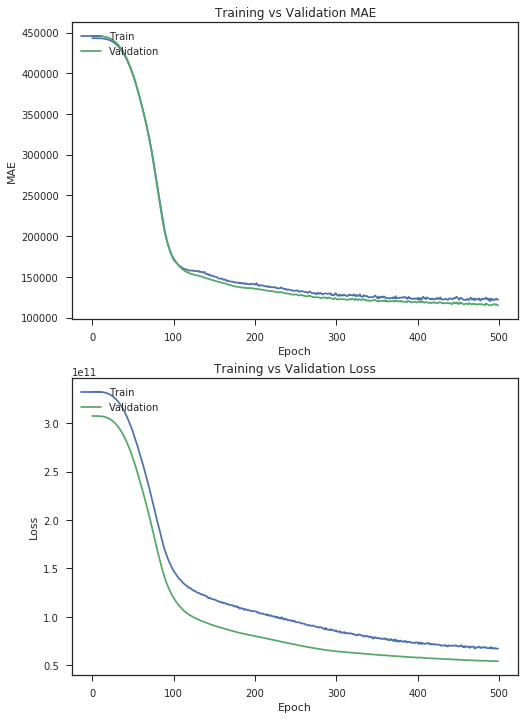

In [28]:
plot_hist(history.history, xsize=8, ysize=12)

### Lets see how well this generalizes to our Test set

Compute the difference between the *predicted* house prices and the
*actual* house prices, then compute the percentage difference and
the absolute percentage difference

In [29]:
preds = model.predict(arr_x_test)

In [30]:
diff = preds - arr_y_test
percentDiff = (diff / arr_y_test) * 100
absPercentDiff = np.abs(percentDiff)

Compute the mean and standard deviation of the absolute percentage
difference

In [31]:
mean = np.mean(absPercentDiff)
print("Mean of the absolute percentage difference: ", mean)
std = np.std(absPercentDiff)
print("Std from the average absolute percentage difference: ", std)

Mean of the absolute percentage difference:  28.882209303431797
Std from the average absolute percentage difference:  45.311154730868495


Unfortunately the average absolute difference is larger than we would like, however the std shows us that the data is very spread out rather than centered around the mean which would explain the results.

In [32]:
print("Average asking price: ", df2["Asking Price"].mean())
print("Standard Deviation from the average asking price: ", df2["Asking Price"].std())

Average asking price:  443771.52459016396
Standard Deviation from the average asking price:  351836.1956816086


As you can see the standard deviation of house prices is almost double the average which will negatively impact our predictions. Therefore concidering the data, this is a good estimate.

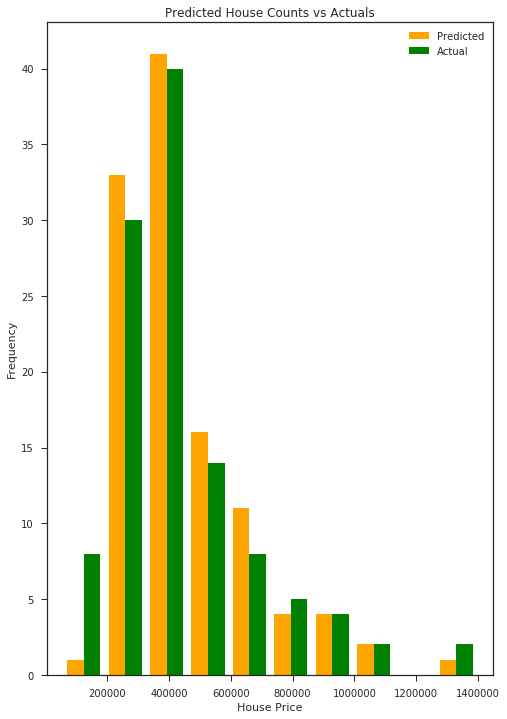

In [33]:
plt.hist([np.squeeze(preds), np.squeeze(arr_y_test)], color=['orange', 'green'])
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.legend(['Predicted', 'Actual'])
plt.xticks()
plt.yticks()
plt.title('Predicted House Counts vs Actuals')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()


In [34]:
bin_counts = [0 for i in range(0,9)]
bin_totals = [0 for i in range(0,9)]
diff = np.abs(np.squeeze(diff))
i = 0
for x in preds:
    if x < 100000:
        bin_counts[0]+=1
        bin_totals[0]+=diff[i]
    elif x < 200000:
        bin_counts[1]+=1
        bin_totals[1]+=diff[i]
    elif x < 300000:
        bin_counts[2]+=1
        bin_totals[2]+=diff[i]
    elif x < 400000:
        bin_counts[3]+=1
        bin_totals[3]+=diff[i]
    elif x < 500000:
        bin_counts[4]+=1
        bin_totals[4]+=diff[i]
    elif x < 600000:
        bin_counts[5]+=1
        bin_totals[5]+=diff[i]
    elif x < 700000:
        bin_counts[6]+=1
        bin_totals[6]+=diff[i]
    elif x < 800000:
        bin_counts[7]+=1
        bin_totals[7]+=diff[i]
    else:
        bin_counts[8]+=1
        bin_totals[8]+=diff[i]
    i+=1

bin_counts = bin_counts[2:]
bin_totals = bin_totals[2:]
bin_averages = (np.array(bin_totals)/np.array(bin_counts)).tolist()

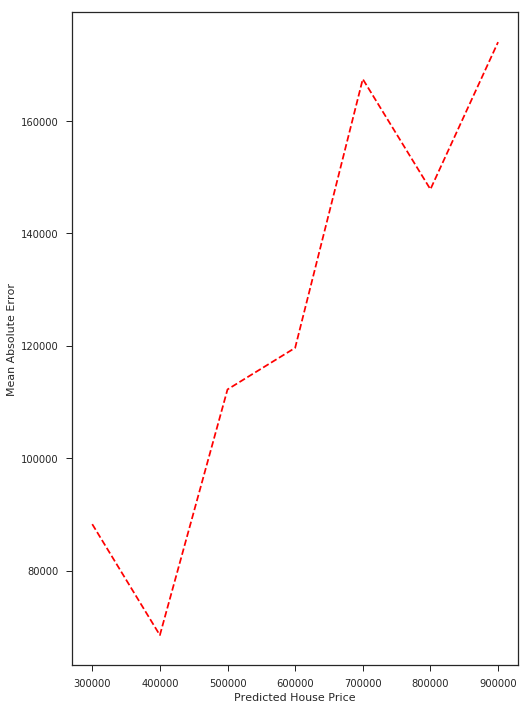

In [35]:
plt.plot([300000,400000,500000,600000,700000,800000,900000],bin_averages, 'r--')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Predicted House Price')
plt.show()